In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import cv2

In [2]:
files = "/home/data_shares/purrlab/physionet.org/files/chexmask-cxr-segmentation-data/0.2"

In [3]:
padchest_masks = pd.read_csv(files+ "/OriginalResolution/Padchest.csv")

/home/caap/.conda/envs/multi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
padchest_masks.head()

,ImageID,Dice RCA (Mean),Dice RCA (Max),Landmarks,Left Lung,Right Lung,Heart,Height,Width
0,216840111366964012487858717522009278090344349_...,0.800701,0.837323,[[1739 368]\n [1534 385]\n [1329 431]\n [11...,1830434 6 1834707 19 1838980 31 1843253 44 184...,1576774 10 1581042 28 1585310 46 1589578 64 15...,5279509 147 5283784 158 5288060 168 5292335 17...,3520.0,4280.0
1,297296042610568106386358000944101882216_oryw2k...,0.82726,0.865835,[[1063 379]\n [ 961 390]\n [ 852 452]\n [ 7...,1084756 8 1087746 22 1090735 37 1093724 52 109...,1138060 6 1141051 18 1144041 31 1147032 43 115...,3853381 77 3856375 96 3859370 113 3862364 132 ...,2667.0,3000.0
2,282304671682231211691601927052092320690_fqq20r...,0.829237,0.871887,[[1182 584]\n [1091 587]\n [ 995 631]\n [ 9...,1614688 7 1617500 21 1620313 33 1623125 47 162...,1645128 17 1647913 51 1650698 85 1653496 106 1...,3680581 68 3683390 80 3686199 92 3689008 104 3...,2624.0,2815.0
3,216840111366964012558082906712010118092605469_...,0.812057,0.836466,[[1576 460]\n [1425 473]\n [1275 544]\n [11...,2005535 154 2009813 160 2014090 166 2018368 17...,1970372 8 1974640 24 1978908 40 1983177 56 198...,7158195 101 7162471 111 7166747 121 7171023 13...,3520.0,4280.0
4,216840111366964012487858717522009264132859659_...,0.802433,0.912305,[[ 649 172]\n [ 589 178]\n [ 523 209]\n [ 4...,271627 5 273282 16 274937 26 276592 36 278247 ...,286166 6 287816 19 289466 33 291116 46 292766 ...,1217632 47 1219272 74 1220920 94 1222578 103 1...,1884.0,1660.0


In [6]:
def rle2mask(mask_rle: str, label=1, shape=(3520,4280)):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = label
    return img.reshape(shape)# Needed to align to RLE direction


def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [7]:
def decode_both_lungs(row, label=1):

    right = rle2mask(
        mask_rle=row["Right Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    )

    left = rle2mask(
        mask_rle=row["Left Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    )

    return right + left

In [8]:
def dilate(image, dilation_rate=1):

    kernel_shape = (dilation_rate*2)+1

    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_shape,kernel_shape))
    dilate = cv2.dilate(image, kernel, iterations=1)

    return dilate

def fast_dilate(image, dilation_rate=1):

    #kernel_shape = (dilation_rate*2)+1

    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    dilate = cv2.dilate(image, kernel, iterations=dilation_rate)

    return dilate


In [16]:
def bounding_box(image, label=1):
    _image = image.copy()
    segmentation = np.where(_image == label)

    if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[0]))
        y_max = int(np.max(segmentation[0]))

    return cv2.rectangle(_image, (x_min, y_min), (x_max, y_max), 1,-1)

In [10]:
def bbox_both_lungs(row, label=1):

    right = bounding_box(rle2mask(
        mask_rle=row["Right Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    ))

    left = bounding_box(rle2mask(
        mask_rle=row["Left Lung"],
        label=label,
        shape=(int(row["Height"]),int(row["Width"]))
    ))

    return right + left

In [11]:
def apply_all_augmentations(row, dilation_factor=300000):
    
    dilation_rate = int(np.round((row["Height"] * row["Width"]) / dilation_factor))

    mask = decode_both_lungs(row)
    bbox = bounding_box(mask)
    bbox_both = bbox_both_lungs(row)

    dilated_masks = [fast_dilate(mask, dilation_rate=dilation_rate*(i+1)) for i in range(4)]

    output_row = {
        "ImageID":row["ImageID"],
        "original_mask":mask2rle(mask),
        "bbox_mask":mask2rle(bbox),
        "bbox_both_mask":mask2rle(bbox_both),
        "dilated_mask_1":mask2rle(dilated_masks[0]),
        "dilated_mask_2":mask2rle(dilated_masks[1]),
        "dilated_mask_3":mask2rle(dilated_masks[2]),
        "dilated_mask_4":mask2rle(dilated_masks[3]),
    }

    return output_row

In [17]:
image = decode_both_lungs(padchest_masks.iloc[0])

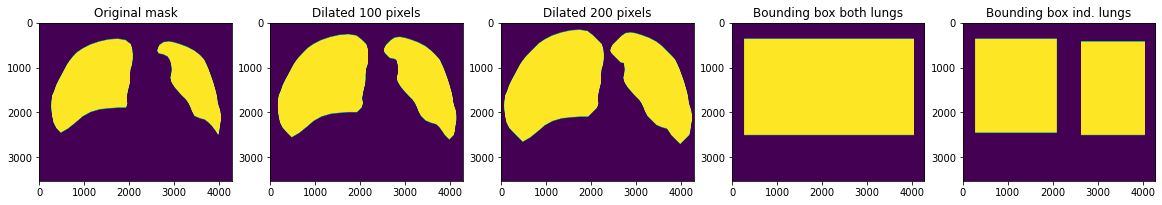

In [21]:

fig, axs = plt.subplots(1, 5, figsize=(20, 50))

axs[0].imshow(image)
axs[0].set_title("Original mask")
axs[1].imshow(fast_dilate(image, 100))
axs[1].set_title("Dilated 100 pixels")
axs[2].imshow(fast_dilate(image, 200))
axs[2].set_title("Dilated 200 pixels")
axs[3].imshow(bounding_box(image))
axs[3].set_title("Bounding box both lungs")
axs[4].imshow(bbox_both_lungs(padchest_masks.iloc[0]))
axs[4].set_title("Bounding box ind. lungs")
plt.show()

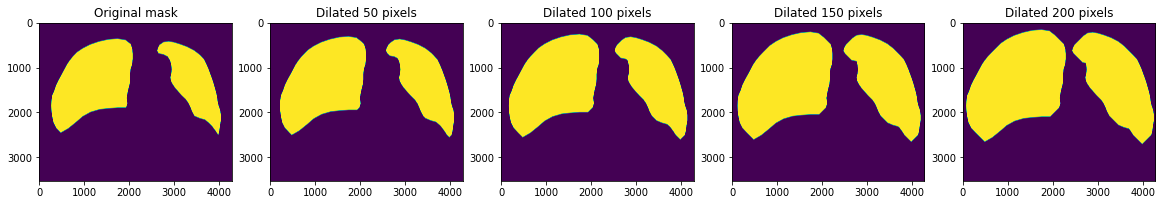

In [22]:
fig, axs = plt.subplots(1, 5, figsize=(20, 50))

axs[0].imshow(image)
axs[0].set_title("Original mask")
axs[1].imshow(fast_dilate(image, 50))
axs[1].set_title("Dilated 50 pixels")
axs[2].imshow(fast_dilate(image, 100))
axs[2].set_title("Dilated 100 pixels")
axs[3].imshow(fast_dilate(image, 150))
axs[3].set_title("Dilated 150 pixels")
axs[4].imshow(fast_dilate(image, 200))
axs[4].set_title("Dilated 200 pixels")
plt.show()